# Garbage image classification V2

We will try to get to a good result by using more images.

We are setting the imports that we need here at the top to have them in a single place

In [1]:
#import numpy for number array handling and represent rgb image pixel values
import numpy as np
import pandas as pd

#import tensorflow to use any tools needed for deep learning
import tensorflow as tf

#import keras api needed to implement deep learning techiques
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint

#import libraries for visualization of data
import matplotlib.pyplot as plt

#Allow charts and graphics to display right below the page of browser setup
%matplotlib inline

import os

# Set the environment variable
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

from sklearn.model_selection import train_test_split

from PIL import Image

## Aggregating data, creating data set

We bring our folder images and we create a data frame.

In [2]:
def list_folders_in_directory(directory):
    folders = [folder for folder in os.listdir(directory) if os.path.isdir(os.path.join(directory, folder))]
    return folders

directory_path = "../v2/Garbage classification/"
folders_list = list_folders_in_directory(directory_path)
print(folders_list)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [3]:
data = []
for folder in folders_list: 
    files = os.listdir(os.path.join(directory_path, folder))
    #Add each file along with its folder name to the data list
    for file in files:
        data.append({'Folder': folder, 'File_name': file, 'Path':os.path.join(directory_path, folder, file)})

# Create a DataFrame from the data list
df = pd.DataFrame(data)

# Display the DataFrame
df.head()



,Folder,File_name,Path
0,cardboard,cardboard.png,../v2/Garbage classification/cardboard\cardboa...
1,cardboard,cardboard1.jpg,../v2/Garbage classification/cardboard\cardboa...
2,cardboard,cardboard10.jpg,../v2/Garbage classification/cardboard\cardboa...
3,cardboard,cardboard100.jpg,../v2/Garbage classification/cardboard\cardboa...
4,cardboard,cardboard101.jpg,../v2/Garbage classification/cardboard\cardboa...


We are getting some information about our images

In [4]:
def get_image_dimensions(df_row):
    file_path = os.path.join(directory_path, df_row['Folder'], df_row['File_name'])
    image = Image.open(file_path)
    width, height = image.size
    channels = image.mode
    return width, height, image.format, channels

df['Image_width'], df['Image_height'], df['Format'], df['Channels'] = zip(*df.apply(get_image_dimensions, axis=1))

df.head()

,Folder,File_name,Path,Image_width,Image_height,Format,Channels
0,cardboard,cardboard.png,../v2/Garbage classification/cardboard\cardboa...,512,384,PNG,RGBA
1,cardboard,cardboard1.jpg,../v2/Garbage classification/cardboard\cardboa...,866,540,JPEG,RGB
2,cardboard,cardboard10.jpg,../v2/Garbage classification/cardboard\cardboa...,512,384,JPEG,RGB
3,cardboard,cardboard100.jpg,../v2/Garbage classification/cardboard\cardboa...,512,384,JPEG,RGB
4,cardboard,cardboard101.jpg,../v2/Garbage classification/cardboard\cardboa...,512,384,JPEG,RGB


We are looking at the format

In [5]:
df['Format'].value_counts()

Format
JPEG    6472
PNG       29
Name: count, dtype: int64

We are looking at the channels of the images.


In [6]:
df.Channels.value_counts()

Channels
RGB     6472
P         28
RGBA       1
Name: count, dtype: int64


It seems that we have a format that will cause use some issues, since we will work with RGB channels. So we will remove them.

In [7]:
df = df.drop(df[df.Channels == 'P'].index)

In [8]:
df.Channels.value_counts()

Channels
RGB     6472
RGBA       1
Name: count, dtype: int64

We can take a look to see how many images we are having on each class.

In [9]:
df.Folder.value_counts()

Folder
glass        2010
paper        1047
cardboard     892
plastic       865
metal         849
trash         810
Name: count, dtype: int64

It seems that the number of glass images is large compared to the other ones.

In [10]:
df[df.Folder == 'glass']

,Folder,File_name,Path,Image_width,Image_height,Format,Channels
892,glass,brown-glass1.jpg,../v2/Garbage classification/glass\brown-glass...,266,189,JPEG,RGB
893,glass,brown-glass10.jpg,../v2/Garbage classification/glass\brown-glass...,230,218,JPEG,RGB
894,glass,brown-glass100.jpg,../v2/Garbage classification/glass\brown-glass...,224,224,JPEG,RGB
895,glass,brown-glass101.jpg,../v2/Garbage classification/glass\brown-glass...,224,224,JPEG,RGB
896,glass,brown-glass102.jpg,../v2/Garbage classification/glass\brown-glass...,225,225,JPEG,RGB
...,...,...,...,...,...,...,...
2898,glass,white-glass95.jpg,../v2/Garbage classification/glass\white-glass...,512,384,JPEG,RGB
2899,glass,white-glass96.jpg,../v2/Garbage classification/glass\white-glass...,512,384,JPEG,RGB
2900,glass,white-glass97.jpg,../v2/Garbage classification/glass\white-glass...,512,384,JPEG,RGB
2901,glass,white-glass98.jpg,../v2/Garbage classification/glass\white-glass...,512,384,JPEG,RGB


We can see that we have different glass colours and we want to remove some of them but to keep some sample from every glass type.

In [11]:
glass_df = df[df.Folder == 'glass']

white_glass_df = glass_df[glass_df['File_name'].str.contains("white")]
green_glass_df = glass_df[glass_df['File_name'].str.contains("green")]
brown_glass_df = glass_df[glass_df['File_name'].str.contains("brown")]

white_glass_df.shape, green_glass_df.shape, brown_glass_df.shape

((774, 7), (629, 7), (607, 7))

We will define a function that will randomly remove half of rows from a dataframe

In [12]:
def remove_glass_images(base_dataframe, dataframe):
    num_rows_to_remove = len(dataframe) // 2

    # Randomly select rows to remove
    rows_to_remove = np.random.choice(dataframe.index, size=num_rows_to_remove, replace=False)

    # Remove selected rows from the original DataFrame
    base_dataframe = base_dataframe.drop(rows_to_remove)

    return base_dataframe

Now we will use that function on our coloured glass dataframes.

In [13]:
df = remove_glass_images(df, white_glass_df)
df = remove_glass_images(df, green_glass_df)
df = remove_glass_images(df, brown_glass_df)

df.Folder.value_counts()

Folder
paper        1047
glass        1006
cardboard     892
plastic       865
metal         849
trash         810
Name: count, dtype: int64

Now that our images are more balanced we can group them so we can easily split them in training data, validation data and test data

In [14]:
grouped = df.groupby('Folder')

grouped.head(1)

,Folder,File_name,Path,Image_width,Image_height,Format,Channels
0,cardboard,cardboard.png,../v2/Garbage classification/cardboard\cardboa...,512,384,PNG,RGBA
894,glass,brown-glass100.jpg,../v2/Garbage classification/glass\brown-glass...,224,224,JPEG,RGB
2903,metal,metal1.jpg,../v2/Garbage classification/metal\metal1.jpg,259,194,JPEG,RGB
3752,paper,paper1.jpg,../v2/Garbage classification/paper\paper1.jpg,275,183,JPEG,RGB
4802,plastic,plastic1.jpg,../v2/Garbage classification/plastic\plastic1.jpg,194,259,JPEG,RGB
5667,trash,trash1 (2).jpg,../v2/Garbage classification/trash\trash1 (2).jpg,512,384,JPEG,RGB


We are creating a dataframe that we will use to test our model.

In [15]:
test_set = pd.DataFrame()

# Iterate over each group
for name, group in grouped:
    # Split each group into train and test sets while maintaining the proportions
    train, test = train_test_split(group, test_size=0.1, random_state=42)  # Adjust test_size as needed
    # Append the test set from the current group to the test_set DataFrame
    test_set = pd.concat([test_set, test])


We can check how many images we have in our test dataframe.

In [16]:
test_set.Folder.value_counts()

Folder
paper        105
glass        101
cardboard     90
plastic       87
metal         85
trash         81
Name: count, dtype: int64

We are removing the test images from the initial dataframe.

In [17]:
df = df.drop(test_set.index)
df.Folder.value_counts()

Folder
paper        942
glass        905
cardboard    802
plastic      778
metal        764
trash        729
Name: count, dtype: int64

We are also creating a dataframe that we will use to validate our model.

In [18]:
validation_set = pd.DataFrame()
grouped = df.groupby('Folder')

# Iterate over each group
for name, group in grouped:
    # Split each group into train and test sets while maintaining the proportions
    train, test = train_test_split(group, test_size=0.2, random_state=42)  # Adjust test_size as needed
    # Append the test set from the current group to the test_set DataFrame
    validation_set = pd.concat([validation_set, test])


We can check how many images we have in our validation dataframe.

In [19]:
validation_set.Folder.value_counts()

Folder
paper        189
glass        181
cardboard    161
plastic      156
metal        153
trash        146
Name: count, dtype: int64

We will remove the validation images from our original dataset.

In [20]:
df = df.drop(validation_set.index)
df.Folder.value_counts()

Folder
paper        753
glass        724
cardboard    641
plastic      622
metal        611
trash        583
Name: count, dtype: int64

We will reset our indexes in all the created dataframes

In [21]:
df.reset_index(drop=True,inplace=True)
validation_set.reset_index(drop=True, inplace=True)
test_set.reset_index(drop=True,inplace=True)

What remained in the initial dataframe will be used for training the model.

In [22]:
df.Folder.value_counts()

Folder
paper        753
glass        724
cardboard    641
plastic      622
metal        611
trash        583
Name: count, dtype: int64

We will create batches of data for train and validation from our dataframes.

Even if we use an ImageDataGenerator that is used for augmentation we will only rescale the values from the images at this point.

In [23]:
image_height = 250
image_width = 250

train_batches = ImageDataGenerator(
    rescale=1./255.,
    ).flow_from_dataframe(
    dataframe=df, 
    x_col = 'Path',
    y_col = 'Folder',
    target_size=(image_height,image_width),
    shuffle=True, 
    class_mode='sparse', 
    batch_size=32)


# extract images to validation set
valid_batches = ImageDataGenerator(
     rescale=1./255.,
   ).flow_from_dataframe(
    dataframe=validation_set,
    x_col = 'Path',
    y_col = 'Folder', 
    target_size=(image_height,image_width),
    shuffle=True, 
    class_mode='sparse', 
    batch_size=32)



Found 3934 validated image filenames belonging to 6 classes.
Found 986 validated image filenames belonging to 6 classes.


We are creating the model

In [71]:
model = Sequential([
    Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(image_height, image_width, 3)),  # Input
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64),
    Dropout(0.2),
    Dense(6)  # 6 classes
])

In [54]:
model = Sequential([
    Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(image_height, image_width, 3)),  # Input
    MaxPooling2D((2, 2)),
    Conv2D(16, (3, 3), padding='same', activation='relu'),
    Conv2D(16, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Droput(0.5),
    Dense(64),
    Dense(32),
    Dense(6) 
 ]) # 6 classes

In [68]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_73 (Conv2D)          (None, 250, 250, 16)      448       
                                                                 
 max_pooling2d_68 (MaxPoolin  (None, 125, 125, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_74 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_69 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_75 (Conv2D)          (None, 62, 62, 32)        9248      
                                                                 
 max_pooling2d_70 (MaxPoolin  (None, 31, 31, 32)     

Compiling the model

In [72]:
model.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss=SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy'])

Creating a function to save only the best model

In [44]:
def create_model_checkpoint(model_path):
    model_checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True)
    return model_checkpoint

Training the model

In [73]:
model_details = model.fit(x=train_batches, validation_data=valid_batches, epochs=30, callbacks=[create_model_checkpoint("initial_model_v2.h5")])

Epoch 1/30
123/123 [==============================] - ETA: 0s - loss: 1.6080 - accuracy: 0.3477
Epoch 1: val_accuracy improved from -inf to 0.50304, saving model to initial_model_v2.h5
123/123 [==============================] - 43s 345ms/step - loss: 1.6080 - accuracy: 0.3477 - val_loss: 1.2274 - val_accuracy: 0.5030
Epoch 2/30
123/123 [==============================] - ETA: 0s - loss: 1.3300 - accuracy: 0.4863
Epoch 2: val_accuracy improved from 0.50304 to 0.55375, saving model to initial_model_v2.h5
123/123 [==============================] - 41s 329ms/step - loss: 1.3300 - accuracy: 0.4863 - val_loss: 1.1673 - val_accuracy: 0.5538
Epoch 3/30
123/123 [==============================] - ETA: 0s - loss: 1.2408 - accuracy: 0.5168
Epoch 3: val_accuracy improved from 0.55375 to 0.56085, saving model to initial_model_v2.h5
123/123 [==============================] - 41s 329ms/step - loss: 1.2408 - accuracy: 0.5168 - val_loss: 1.1417 - val_accuracy: 0.5609
Epoch 4/30
123/123 [=================

KeyboardInterrupt: 

In [221]:
model = tf.keras.models.load_model("initial_model_v2.h5")

We can see that we have an improvement from the other version where we had a lower validation accuracy at this point.

We will try to augment the data that we have to see if the performance is improving

In [181]:
train_batches = ImageDataGenerator(
    rescale=1./255.,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    ).flow_from_dataframe(
    dataframe=df, 
    x_col = 'Path',
    y_col = 'Folder',target_size=(image_height,image_width),shuffle=True, class_mode='sparse', batch_size=32)


# extract images to validation set
valid_batches = ImageDataGenerator(
     rescale=1./255.,
   ).flow_from_dataframe(
    dataframe=validation_set,
    x_col = 'Path',
    y_col = 'Folder', target_size=(image_height,image_width),shuffle=True, class_mode='sparse', batch_size=32)

Found 3933 validated image filenames belonging to 6 classes.
Found 986 validated image filenames belonging to 6 classes.


We will compile again the model.

In [177]:
model.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss=SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy'])

In [178]:
model_details = model.fit(x=train_batches, validation_data=valid_batches, epochs=20, callbacks=[create_model_checkpoint("initial_model_v2.h5")])

Epoch 1/20
123/123 [==============================] - ETA: 0s - loss: 0.6956 - accuracy: 0.7506
Epoch 1: val_accuracy improved from -inf to 0.70892, saving model to initial_model_v2.h5
123/123 [==============================] - 75s 603ms/step - loss: 0.6956 - accuracy: 0.7506 - val_loss: 0.8569 - val_accuracy: 0.7089
Epoch 2/20
123/123 [==============================] - ETA: 0s - loss: 0.6769 - accuracy: 0.7559
Epoch 2: val_accuracy improved from 0.70892 to 0.72008, saving model to initial_model_v2.h5
123/123 [==============================] - 75s 608ms/step - loss: 0.6769 - accuracy: 0.7559 - val_loss: 0.8239 - val_accuracy: 0.7201
Epoch 3/20
123/123 [==============================] - ETA: 0s - loss: 0.6641 - accuracy: 0.7562
Epoch 3: val_accuracy improved from 0.72008 to 0.73022, saving model to initial_model_v2.h5
123/123 [==============================] - 75s 607ms/step - loss: 0.6641 - accuracy: 0.7562 - val_loss: 0.8374 - val_accuracy: 0.7302
Epoch 4/20
123/123 [=================

In [234]:
#model.save("models/more_garbage_pretrained.h5")

loaded_model = tf.keras.models.load_model('original_garbage_2.h5')

In [235]:
loaded_model.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss=SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy'])

In [238]:
model_details = loaded_model.fit(x=train_batches, validation_data=valid_batches, epochs=30, callbacks=[early_stopping, model_checkpoint])

Epoch 1/30
127/127 [==============================] - ETA: 0s - loss: 0.2030 - accuracy: 0.9172
Epoch 1: val_accuracy did not improve from 0.88409
127/127 [==============================] - 35s 275ms/step - loss: 0.2030 - accuracy: 0.9172 - val_loss: 0.4483 - val_accuracy: 0.8664
Epoch 2/30
127/127 [==============================] - ETA: 0s - loss: 0.2227 - accuracy: 0.9103
Epoch 2: val_accuracy did not improve from 0.88409
127/127 [==============================] - 34s 270ms/step - loss: 0.2227 - accuracy: 0.9103 - val_loss: 0.4209 - val_accuracy: 0.8664
Epoch 3/30
127/127 [==============================] - ETA: 0s - loss: 0.2165 - accuracy: 0.9153
Epoch 3: val_accuracy did not improve from 0.88409
127/127 [==============================] - 36s 280ms/step - loss: 0.2165 - accuracy: 0.9153 - val_loss: 0.4252 - val_accuracy: 0.8605
Epoch 4/30
127/127 [==============================] - ETA: 0s - loss: 0.2175 - accuracy: 0.9064
Epoch 4: val_accuracy did not improve from 0.88409
127/127 [=

In [239]:
test_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_v3.preprocess_input,
   ).flow_from_dataframe(
    dataframe=test_set,
    x_col = 'Path',
    y_col = 'Folder', target_size=(224,224),shuffle=False, class_mode='sparse', batch_size=16)

Found 283 validated image filenames belonging to 3 classes.


In [240]:
loaded_model.evaluate(test_batches)

18/18 [==============================] - 1s 55ms/step - loss: 40.5297 - accuracy: 0.3958


[40.52971649169922, 0.3957597315311432]

In [139]:
probability_model = tf.keras.Sequential([loaded_model, 
                                         tf.keras.layers.Softmax()])

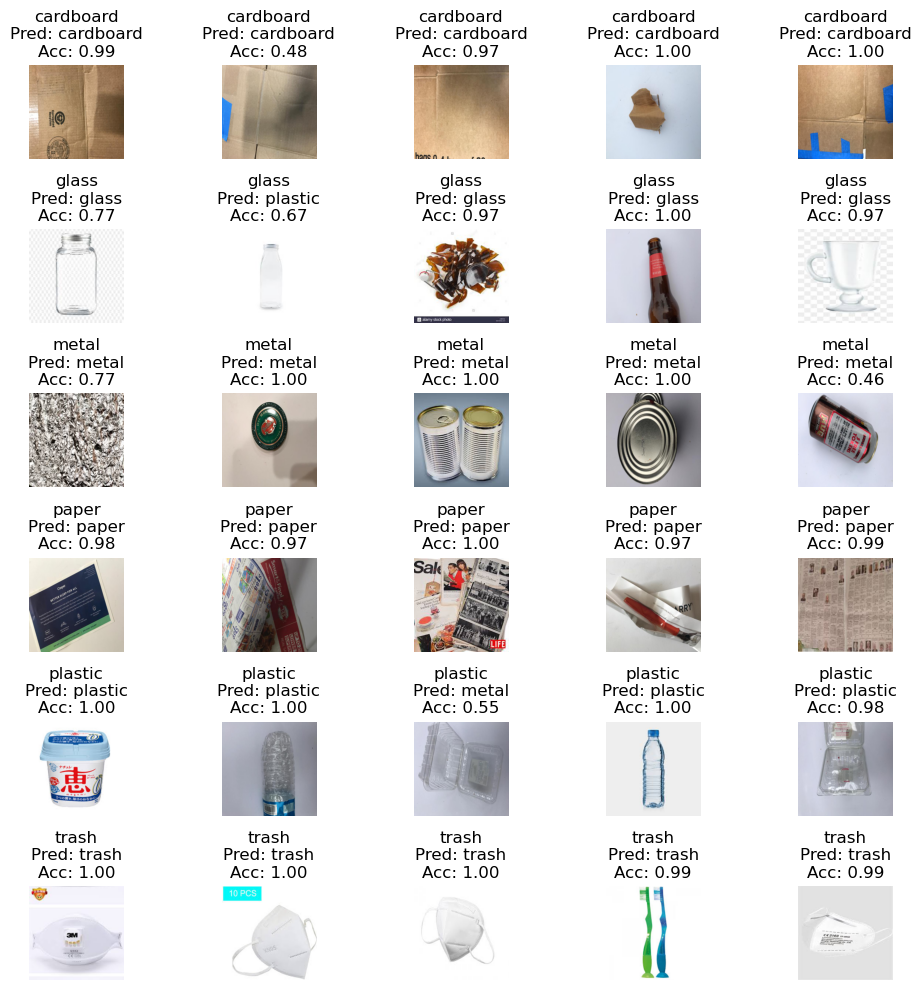

In [140]:
import os
import matplotlib.pyplot as plt
from PIL import Image

#data_directory = "validation_images"

#probability_model = tf.keras.models.load_model('../models\model_pretrained.h5')
test_set = test_set.sample(frac=1, random_state=42)
class_names = sorted(test_set.Folder.unique())

plt.figure(figsize=(10, 10))
new_dataset = pd.DataFrame()
num_images_per_class = 5
grouped = test_set.groupby("Folder")
new_dataset = grouped.head(num_images_per_class)
new_dataset.reset_index(drop=True, inplace=True)

for class_index, class_name in enumerate(class_names):
    class_images = []
    class_predictions =[]
    class_accuracy =[]
    
    #class_path = os.path.join(data_directory, class_name)
    for index, row in new_dataset[new_dataset.Folder == class_name].iterrows():
        img_path = row['Path']
        image = Image.open(img_path)

        image = image.resize((224, 224))  # Replace 'width' and 'height' with desired dimensions

            # Convert the image to a numpy array
        image_array = np.array(image)

            # Convert the numpy array to a TensorFlow tensor
        image_tensor = tf.convert_to_tensor(image_array, dtype=tf.float32) / 255.0

            # Expand the dimensions of the tensor to match the expected input shape
        image_tensor = tf.expand_dims(image_tensor, axis=0)
            
        predictions = probability_model.predict(image_tensor, verbose=0)
        predicted_index = np.argmax(predictions)
        predicted_label = class_names[predicted_index]
        accuracy = np.round(np.max(predictions), 2)
        class_images.append(image)
        class_predictions.append("\nPred: "+ predicted_label)
        class_accuracy.append(f"\nAcc: {accuracy:.2f}")
    
    for k in range(num_images_per_class):
        if k < len(class_images):
            plt.subplot(len(class_names), num_images_per_class, class_index * num_images_per_class + k + 1)
            plt.imshow(class_images[k])
            plt.title(class_name + class_predictions[k] + class_accuracy[k])
            plt.axis("off")

plt.tight_layout()
plt.show()

In [141]:
loaded_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_192 (Batch  (None, 111, 111, 32  96         ['conv2d_188[0][0]']             
 Normalization)                 )                                                           

In [142]:
loaded_model.trainable = True

for layer in loaded_model.layers[:249]:
    layer.trainable = False

loaded_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_192 (Batch  (None, 111, 111, 32  96         ['conv2d_188[0][0]']             
 Normalization)                 )                                                           

In [145]:
loaded_model.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss=SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy'])

In [146]:
loaded_model_details = loaded_model.fit(x=train_batches, validation_data=valid_batches, epochs=20, callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
236/236 [==============================] - ETA: 0s - loss: 0.6397 - accuracy: 0.7858
Epoch 1: val_accuracy did not improve from 0.89652
236/236 [==============================] - 135s 554ms/step - loss: 0.6397 - accuracy: 0.7858 - val_loss: 0.5940 - val_accuracy: 0.8310
Epoch 2/20
236/236 [==============================] - ETA: 0s - loss: 0.3769 - accuracy: 0.8610
Epoch 2: val_accuracy improved from 0.89652 to 0.89757, saving model to with_callbacks.h5
236/236 [==============================] - 138s 584ms/step - loss: 0.3769 - accuracy: 0.8610 - val_loss: 0.3304 - val_accuracy: 0.8976
Epoch 3/20
236/236 [==============================] - ETA: 0s - loss: 0.3468 - accuracy: 0.8811
Epoch 3: val_accuracy improved from 0.89757 to 0.91130, saving model to with_callbacks.h5
236/236 [==============================] - 137s 581ms/step - loss: 0.3468 - accuracy: 0.8811 - val_loss: 0.2727 - val_accuracy: 0.9113
Epoch 4/20
236/236 [==============================] - ETA: 0s - loss: 0.2763

In [149]:
loaded_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_192 (Batch  (None, 111, 111, 32  96         ['conv2d_188[0][0]']             
 Normalization)                 )                                                           

In [147]:
loaded_model = tf.keras.models.load_model("with_callbacks.h5")

In [150]:
probability_model = tf.keras.Sequential([loaded_model, 
                                         tf.keras.layers.Softmax()])

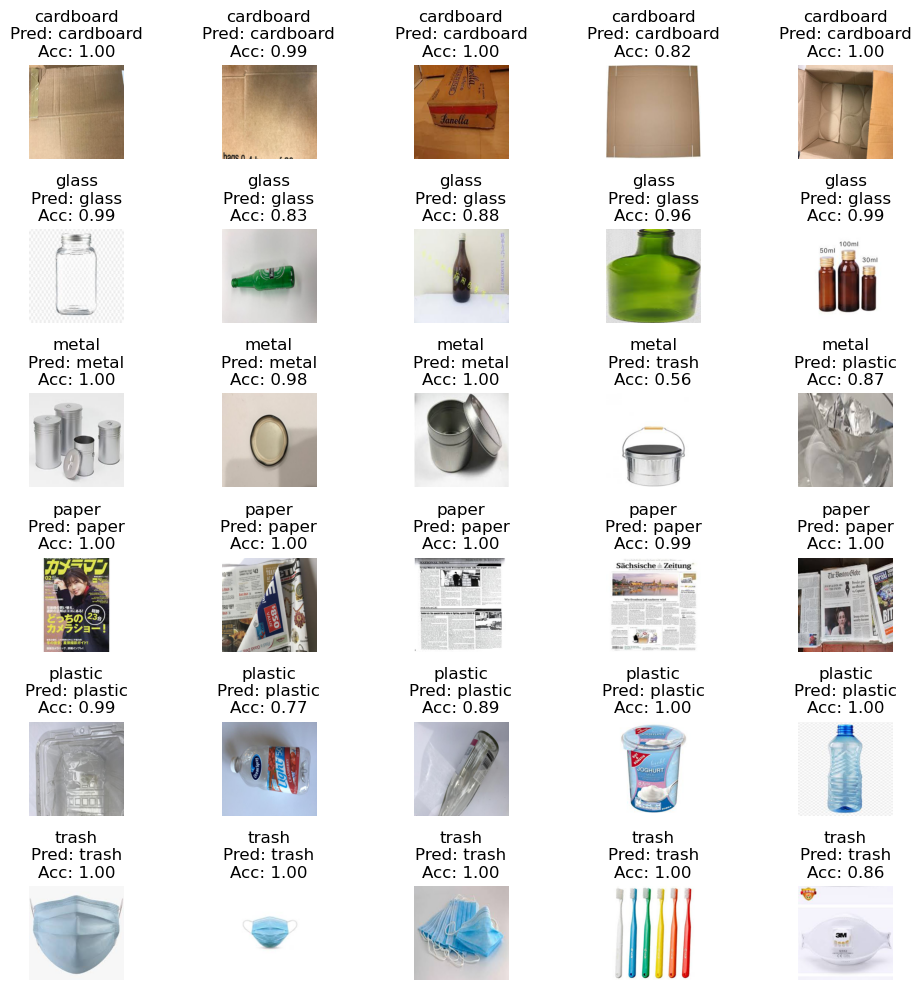

In [151]:
import os
import matplotlib.pyplot as plt
from PIL import Image

#data_directory = "validation_images"

#probability_model = tf.keras.models.load_model('../models\model_pretrained.h5')
test_set = test_set.sample(frac=1, random_state=42)
class_names = sorted(test_set.Folder.unique())

plt.figure(figsize=(10, 10))
new_dataset = pd.DataFrame()
num_images_per_class = 5
grouped = test_set.groupby("Folder")
new_dataset = grouped.head(num_images_per_class)
new_dataset.reset_index(drop=True, inplace=True)

for class_index, class_name in enumerate(class_names):
    class_images = []
    class_predictions =[]
    class_accuracy =[]
    
    #class_path = os.path.join(data_directory, class_name)
    for index, row in new_dataset[new_dataset.Folder == class_name].iterrows():
        img_path = row['Path']
        image = Image.open(img_path)

        image = image.resize((224, 224))  # Replace 'width' and 'height' with desired dimensions

            # Convert the image to a numpy array
        image_array = np.array(image)

            # Convert the numpy array to a TensorFlow tensor
        image_tensor = tf.convert_to_tensor(image_array, dtype=tf.float32) / 255.0

            # Expand the dimensions of the tensor to match the expected input shape
        image_tensor = tf.expand_dims(image_tensor, axis=0)
            
        predictions = probability_model.predict(image_tensor, verbose=0)
        predicted_index = np.argmax(predictions)
        predicted_label = class_names[predicted_index]
        accuracy = np.round(np.max(predictions), 2)
        class_images.append(image)
        class_predictions.append("\nPred: "+ predicted_label)
        class_accuracy.append(f"\nAcc: {accuracy:.2f}")
    
    for k in range(num_images_per_class):
        if k < len(class_images):
            plt.subplot(len(class_names), num_images_per_class, class_index * num_images_per_class + k + 1)
            plt.imshow(class_images[k])
            plt.title(class_name + class_predictions[k] + class_accuracy[k])
            plt.axis("off")

plt.tight_layout()
plt.show()

In [152]:
def prediction_generator(test_images):
    k = 0
    for x in test_images:
        k += len(x[1])
        yield x[0], x[1]  # Passing single tensor to the model
        if k >= test_images.n:
            break


In [153]:
evaluate_results = loaded_model.evaluate(test_batches)

33/33 [==============================] - 10s 284ms/step - loss: 0.2846 - accuracy: 0.9167


In [154]:
probability_model = tf.keras.Sequential([loaded_model, 
                                         tf.keras.layers.Softmax()])

In [155]:
from sklearn.metrics import accuracy_score
proba=probability_model.predict(prediction_generator(test_batches))
predicted = np.argmax(proba, axis=1).tolist()
true=test_batches.labels
accuracy_score(predicted, true)

33/33 [==============================] - 12s 309ms/step


0.9166666666666666

In [136]:
test_set.Folder.value_counts()

Folder
paper        105
glass        101
cardboard     90
plastic       87
metal         77
trash         68
Name: count, dtype: int64

[[ 87   0   2   1   0   0]
 [  0  81   7   1  12   0]
 [  2   2  67   3   3   0]
 [  1   0   0 104   0   0]
 [  0   1   3   3  80   0]
 [  0   0   0   1   2  65]]


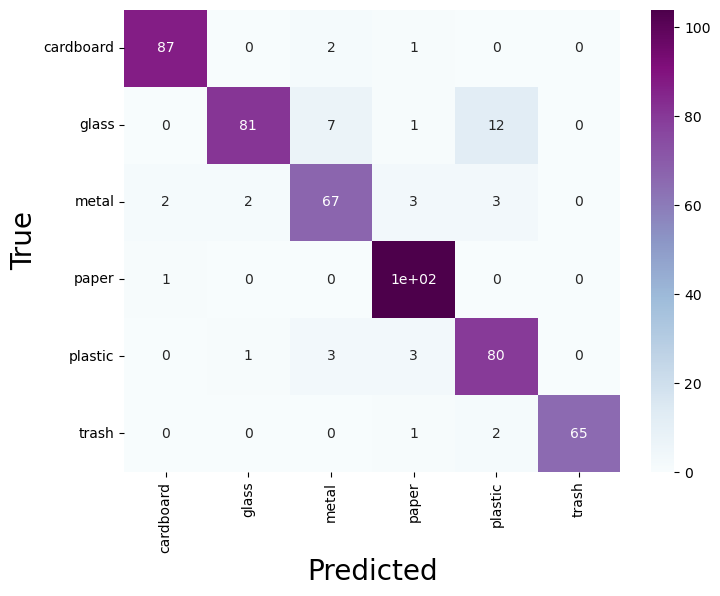

In [156]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_=test_batches.class_indices.keys()
cm = confusion_matrix(true, predicted)

print(cm)

fig = plt.figure(figsize=(8, 6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,cmap="BuPu"); 
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_, fontsize = 10)
plt.yticks(rotation=0)

plt.title('', fontsize=60)

plt.show()

In [157]:
loaded_model = tf.keras.models.load_model("with_callbacks.h5")

In [158]:
loaded_model.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss=SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy'])

In [159]:
loaded_model_details = loaded_model.fit(x=train_batches, validation_data=valid_batches, epochs=20, callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
236/236 [==============================] - ETA: 0s - loss: 0.1605 - accuracy: 0.9449
Epoch 1: val_accuracy improved from 0.92291 to 0.94403, saving model to with_callbacks.h5
236/236 [==============================] - 131s 538ms/step - loss: 0.1605 - accuracy: 0.9449 - val_loss: 0.1929 - val_accuracy: 0.9440
Epoch 2/20
236/236 [==============================] - ETA: 0s - loss: 0.1217 - accuracy: 0.9597
Epoch 2: val_accuracy did not improve from 0.94403
236/236 [==============================] - 128s 542ms/step - loss: 0.1217 - accuracy: 0.9597 - val_loss: 0.1909 - val_accuracy: 0.9398
Epoch 3/20
236/236 [==============================] - ETA: 0s - loss: 0.1146 - accuracy: 0.9616
Epoch 3: val_accuracy did not improve from 0.94403
236/236 [==============================] - 129s 546ms/step - loss: 0.1146 - accuracy: 0.9616 - val_loss: 0.1915 - val_accuracy: 0.9440
Epoch 4/20
236/236 [==============================] - ETA: 0s - loss: 0.0999 - accuracy: 0.9680
Epoch 4: val_accura

In [160]:
loaded_model = tf.keras.models.load_model("with_callbacks.h5")

probability_model = tf.keras.Sequential([loaded_model, 
                                         tf.keras.layers.Softmax()])

In [161]:
from sklearn.metrics import accuracy_score
proba=probability_model.predict(prediction_generator(test_batches))
predicted = np.argmax(proba, axis=1).tolist()
true=test_batches.labels
accuracy_score(predicted, true)

33/33 [==============================] - 10s 280ms/step


0.9507575757575758

[[ 88   0   1   1   0   0]
 [  0  91   1   1   8   0]
 [  1   2  71   0   3   0]
 [  1   0   1 103   0   0]
 [  1   2   2   1  81   0]
 [  0   0   0   0   0  68]]


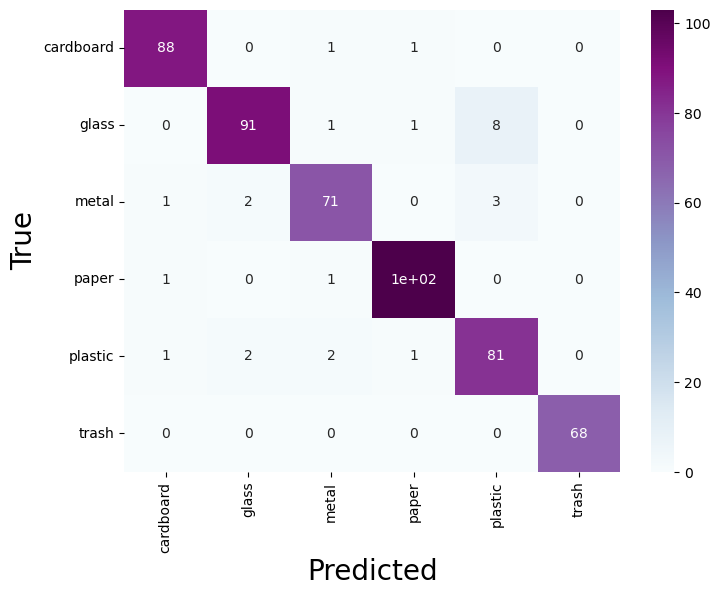

In [162]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_=test_batches.class_indices.keys()
cm = confusion_matrix(true, predicted)

print(cm)

fig = plt.figure(figsize=(8, 6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,cmap="BuPu"); 
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_, fontsize = 10)
plt.yticks(rotation=0)

plt.title('', fontsize=60)

plt.show()